# Introduction
Suite aux conseils de Thomas, on cherche dans ce notebook à appliquer deux optimisations :
* Supprimer des variables synthétiques n'aidant pas le modèle
* Observer à quel point le modèle se trompe lorsque son indice de confiance est haut

# Import

In [1]:
# Import des librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint
import shap

In [3]:
# Import des données 
df = pd.read_csv('../csv/N100_fundamentals_v3.csv')
df = df.sort_values(by='date')
df['index'] = df.symbol + '_' + df.calendarYear.astype('string')
df = df.set_index('index')
df.isna().sum()

symbol                           0
calendarYear                     0
marketCap                        0
marginProfit                     0
roe                              0
roic                             0
revenuePerShare                  0
netIncomePerShare                0
debtToEquity                     0
peRatio                          0
shareValue                       0
marketCap_YoY_Growth            94
marginProfit_YoY_Growth         94
roe_YoY_Growth                  94
roic_YoY_Growth                 94
revenuePerShare_YoY_Growth      94
netIncomePerShare_YoY_Growth    94
debtToEquity_YoY_Growth         94
peRatio_YoY_Growth              94
shareValue_YoY_Growth           94
date                             0
date_NY                          0
benchmark                        0
return                          94
target                           0
dtype: int64

# Preprocessing
On a procédé ici de manière itérative en supprimant les colonnes qui n'aidaient pas le modèle. 
A noter que le peRatio a été supprimé au profit de l'earningYields (E/P), qui fournit une métrique continue et interprétable en gérant naturellement les bénéfices négatifs ou nuls, évitant les problèmes d'interprétation et les valeurs infinies du P/E.

In [4]:
df_final = df.dropna()

# Création de l'E/P
df_final['earningsYield'] = df_final['netIncomePerShare'] / df_final ['shareValue']
df_final = df_final.drop(['return', 
                      'date_NY', 
                      'date', 
                      'benchmark', 
                      'symbol', 
                      'calendarYear',
                      'shareValue', 
                      'peRatio_YoY_Growth',
                      'peRatio',
                      'shareValue_YoY_Growth',
                      'marketCap_YoY_Growth',
                      # A partir d'ici, les colonnes suivantes on été supprimmées
                      # Si elle n'aidaient pas le modèle
                      'roe_YoY_Growth',               # Première suppression
                      'roic_YoY_Growth',              # Seconde
                      'netIncomePerShare_YoY_Growth', # etc
                      'debtToEquity_YoY_Growth',
                      'netIncomePerShare',
                      'marginProfit_YoY_Growth'], axis=1)
df_final.columns

Index(['marketCap', 'marginProfit', 'roe', 'roic', 'revenuePerShare',
       'debtToEquity', 'revenuePerShare_YoY_Growth', 'target',
       'earningsYield'],
      dtype='object')

In [5]:
# Dichotomisation des sets d'entraînement et validation (2021-2022 / 2023)
condition = df_final.index.str.contains('2023')
X_test = df_final[condition]
X_train = df_final[~condition]
y_test = X_test.target
y_train = X_train.target
X_train = X_train.drop('target', axis=1)
X_test = X_test.drop('target', axis=1)
y_test.value_counts()

target
0    60
1    31
Name: count, dtype: int64

# Recherche d'hyperparamètres

In [14]:
# Recherche des hyperparamètres via RandomizedSearchCV
rf = RandomForestClassifier()

param_distributions = {
    'n_estimators': randint(low=50, high=500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(low=2, high=20),
    'min_samples_leaf': randint(low=1, high=10),
    'max_features': ['sqrt', 'log2', None], 
    'criterion': ['gini', 'entropy']
}
tscv = TimeSeriesSplit(n_splits=2)
scoring_metric = 'precision'

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100, # Nombre de combinaisons à tester
    cv=tscv, # Utiliser notre TimeSeriesSplit object
    scoring=scoring_metric, # La métrique à optimiser
    n_jobs=-1, # Utiliser tous les cœurs
    verbose=0
)

search.fit(X_train, y_train)
print('-'*50)
print(f'Meilleurs paramètres : {search.best_params_}')
print('\n')
print('-'*50)
print(f'Meilleur score : {search.best_score_}')
print('-'*50)
print('\n')

# Résultats
y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_true = y_test, y_pred = y_pred))
print('\n')
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

--------------------------------------------------
Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 390}


--------------------------------------------------
Meilleur score : 0.4513888888888889
--------------------------------------------------


              precision    recall  f1-score   support

           0       0.71      0.65      0.68        60
           1       0.42      0.48      0.45        31

    accuracy                           0.59        91
   macro avg       0.56      0.57      0.56        91
weighted avg       0.61      0.59      0.60        91





Classe prédite,0,1
Classe réelle,,
0,39,21
1,16,15


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import precision_score, classification_report, make_scorer
from scipy.stats import randint
import pandas as pd

scorer = make_scorer(precision_score, pos_label=1)

# Target and stopping criteria
target_class = 1
min_precision = 0.7
max_iter = 20
precision = 0
i = 0

# To track the best result
best_precision = 0
best_report = None
best_cm = None
best_model = None
best_params = None

while precision < min_precision and i < max_iter:
    print(f"--- Attempt {i+1} ---")
    
    rf = RandomForestClassifier(random_state=None)

    param_distributions = {
        'n_estimators': randint(low=50, high=500),
        'max_depth': [10, 20, 30, None],
        'min_samples_split': randint(low=2, high=20),
        'min_samples_leaf': randint(low=1, high=10),
        'max_features': ['sqrt', 'log2', None], 
        'criterion': ['gini', 'entropy']
    }

    tscv = TimeSeriesSplit(n_splits=2)
    scoring_metric = 'precision'

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=100,
        cv=tscv,
        scoring=scoring_metric,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train, y_train)

    y_pred = search.best_estimator_.predict(X_test)
    precision = precision_score(y_test, y_pred, pos_label=target_class)

    print(f"Precision (class {target_class}) = {precision:.4f}")
    
    if precision > best_precision:
        best_precision = precision
        best_model = search.best_estimator_
        best_params = search.best_params_
        best_report = classification_report(y_test, y_pred)
        best_cm = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Pred'])

    i += 1
    print("-"*50)

# Final output
print("\n=== BEST RESULT ===")
print(f"Best precision (class {target_class}) = {best_precision:.4f}")
print(f"Best parameters: {best_params}")
print("\nClassification report:\n")
print(best_report)
print("\nConfusion matrix:")
display(best_cm)


--- Attempt 1 ---
Precision (class 1) = 0.4138
--------------------------------------------------
--- Attempt 2 ---
Precision (class 1) = 0.4828
--------------------------------------------------
--- Attempt 3 ---
Precision (class 1) = 0.4444
--------------------------------------------------
--- Attempt 4 ---
Precision (class 1) = 0.4242
--------------------------------------------------
--- Attempt 5 ---
Precision (class 1) = 0.4688
--------------------------------------------------
--- Attempt 6 ---
Precision (class 1) = 0.4286
--------------------------------------------------
--- Attempt 7 ---
Precision (class 1) = 0.4667
--------------------------------------------------
--- Attempt 8 ---
Precision (class 1) = 0.4444
--------------------------------------------------
--- Attempt 9 ---
Precision (class 1) = 0.5000
--------------------------------------------------
--- Attempt 10 ---
Precision (class 1) = 0.4348
--------------------------------------------------
--- Attempt 11 ---


KeyboardInterrupt: 

In [6]:
negative_class = 0
positive_class = 1

y_true_np = y_test.values
y_pred_np = y_pred
indices = X_test.index

tp_indices = indices[(y_true_np == positive_class) & (y_pred_np == positive_class)].tolist()
fp_indices = indices[(y_true_np == negative_class) & (y_pred_np == positive_class)].tolist()
tn_indices = indices[(y_true_np == negative_class) & (y_pred_np == negative_class)].tolist()
fn_indices = indices[(y_true_np == positive_class) & (y_pred_np == negative_class)].tolist()

model = search.best_estimator_

explainer = shap.TreeExplainer(model,
    data=X_train,
    feature_perturbation="interventional",
    model_output="probability")
shap.initjs()

shap_values = explainer.shap_values(X_test) 

fp_iloc = X_test.index.get_indexer(fp_indices)
for index in fp_iloc:
    print(f'Faux positifs - Entreprise et année concernée : {X_test.iloc[index,:].name}')
    print('\n')
    display(shap.force_plot(explainer.expected_value[1], shap_values[1][index, :], X_test.iloc[index,:]))
    print('-'*50)

Faux positifs - Entreprise et année concernée : ADSK_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : TTWO_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : MCHP_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : CSCO_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : CPRT_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : AMD_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : TXN_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : ODFL_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : WBD_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : CDNS_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : CSGP_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : FAST_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : DDOG_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : DXCM_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : MNST_2023




--------------------------------------------------
Faux positifs - Entreprise et année concernée : ASML_2023




--------------------------------------------------


# Meilleur modèle trouvé

In [7]:
# Meilleurs hyperparamètres trouvés pour le RFC
best = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 'log2', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 134, random_state = 42)
best.fit(X_train, y_train)

# Résultats
pred_best = best.predict(X_test)

print('\n')
print('-'*70)
print(f'Score des meilleurs hyperpramètres : {best.score(X_test, y_test)}')
print('-'*70)
print('\n')
print(classification_report(y_true = y_test, y_pred = pred_best))
print('\n')
cm_best = pd.crosstab(y_test, pred_best, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm_best



----------------------------------------------------------------------
Score des meilleurs hyperpramètres : 0.6813186813186813
----------------------------------------------------------------------


              precision    recall  f1-score   support

           0       0.76      0.75      0.76        60
           1       0.53      0.55      0.54        31

    accuracy                           0.68        91
   macro avg       0.65      0.65      0.65        91
weighted avg       0.68      0.68      0.68        91





Classe prédite,0,1
Classe réelle,,
0,45,15
1,14,17


# Analyse des prédictions à haute confiance

DataFrame combiné créé avec succès pour identifier les cas.


,true_label,prediction,confidence,is_correct,shap_sum
index,,,,,
MRVL_2023,1,0,0.558027,0,0.235706
NVDA_2023,1,1,0.559002,1,0.231742
CRWD_2023,1,0,0.690899,0,0.220705
WDAY_2023,1,0,0.505195,0,0.201322
ADSK_2023,0,0,0.505079,1,0.195680



Analyse des prédictions avec confiance > 0.7:
Nombre total de prédictions à haute confiance : 18
Nombre de prédictions correctes à haute confiance : 15
Nombre de prédictions incorrectes à haute confiance : 3
Affichage des Force plots pour chaque instance incorrecte à haute confiance (valeurs arrondies à 3 décimales)...

--------------------------------------------------
Instance 1/3 avec index: CPRT_2023
  True Label: 0, Predicted: 1, Confidence: 0.71
Affichage du Force plot...


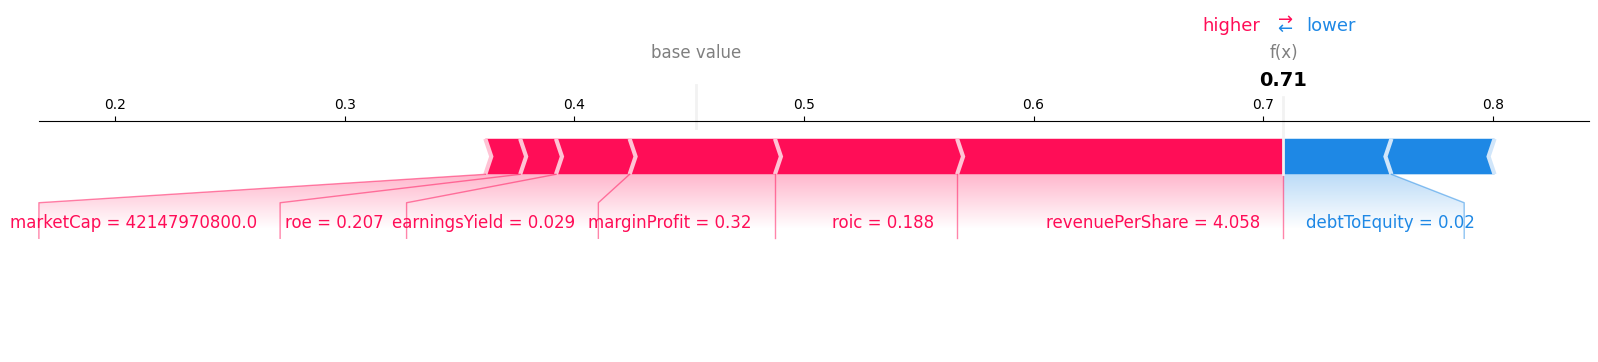


--------------------------------------------------
Instance 2/3 avec index: BKNG_2023
  True Label: 1, Predicted: 0, Confidence: 0.77
Affichage du Force plot...


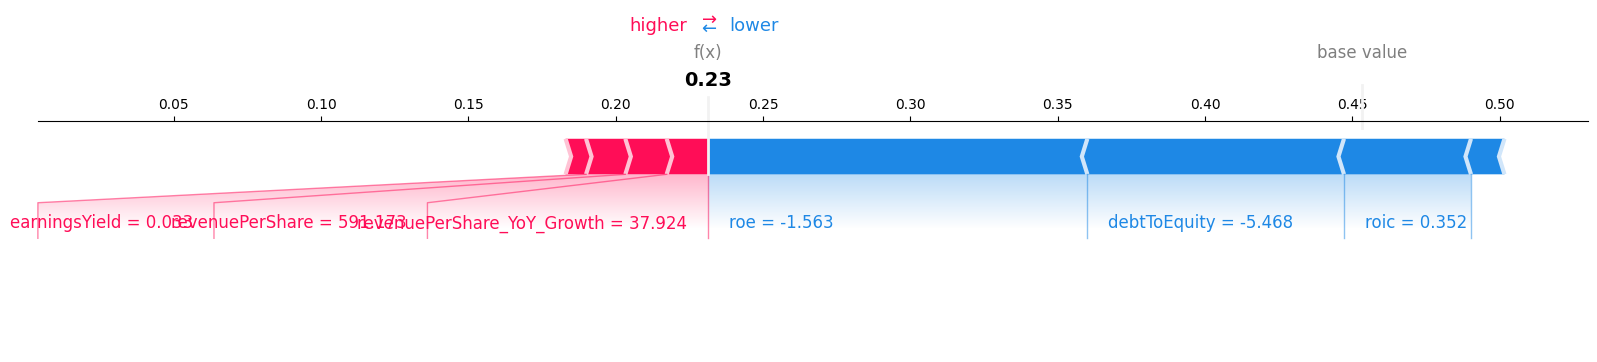


--------------------------------------------------
Instance 3/3 avec index: FTNT_2023
  True Label: 1, Predicted: 0, Confidence: 0.75
Affichage du Force plot...


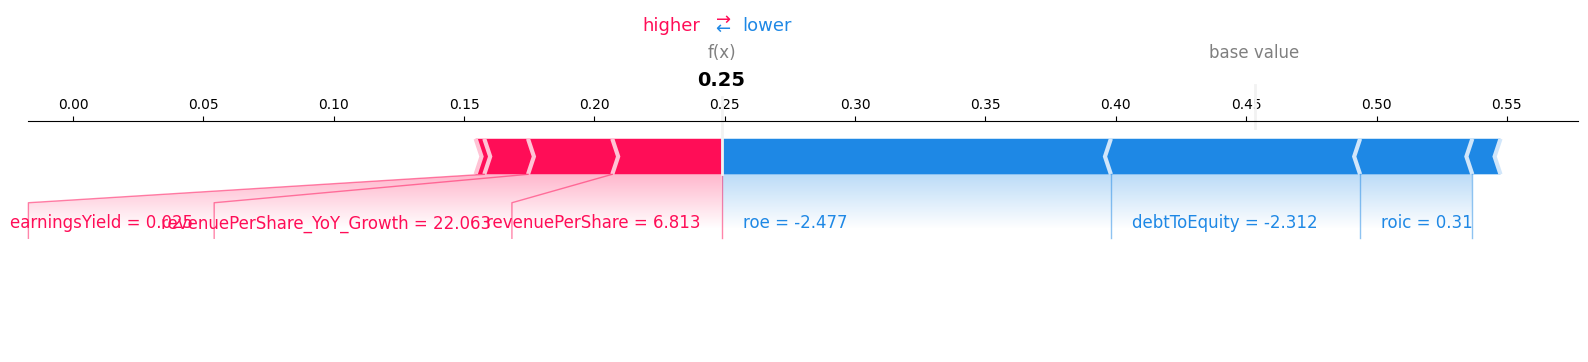

In [8]:
# --- 1. & 2. Obtenir Prédictions, Probabilités et Vraies Étiquettes ---
predictions = best.predict(X_test)
probabilities = best.predict_proba(X_test) # Donne un tableau de probabilités [proba_classe_0, proba_classe_1]

# 3. Calculer le Niveau de Confiance pour la classe prédite
confidence = np.max(probabilities, axis=1)

# 4. Déterminer la correction
is_correct = (predictions == y_test).astype(int) # 1 si correct, 0 si incorrect

explainer = shap.TreeExplainer(best,
    data=X_train,
    feature_perturbation="interventional",
    model_output="probability")

# 5. Récupérer les shap values
shap_values = explainer.shap_values(X_test)
shap_values_for_analysis = shap_values[1] # SHAP values expliquant la probabilité de la classe 1

# --- 6. Combiner les informations dans un DataFrame (pour faciliter le filtrage) ---
# Copier X_test pour ajouter les colonnes supplémentaires, en conservant l'index original
df_combined = X_test.copy()
df_combined['true_label'] = y_test.values
df_combined['prediction'] = predictions
df_combined['confidence'] = confidence
df_combined['is_correct'] = is_correct
df_combined['shap_sum'] = np.sum(np.abs(shap_values_for_analysis), axis=1)

print("DataFrame combiné créé avec succès pour identifier les cas.")
display(df_combined[['true_label', 'prediction', 'confidence', 'is_correct', 'shap_sum']].head())

# --- 7. Filtrer pour les prédictions incorrectes à haute confiance ---
confidence_threshold = 0.7

# Filtrer les instances à haute confiance
high_confidence_predictions = df_combined[df_combined['confidence'] > confidence_threshold].copy()

print(f"\nAnalyse des prédictions avec confiance > {confidence_threshold}:")
print(f"Nombre total de prédictions à haute confiance : {len(high_confidence_predictions)}")
print(f"Nombre de prédictions correctes à haute confiance : {high_confidence_predictions['is_correct'].sum()}")
print(f"Nombre de prédictions incorrectes à haute confiance : {len(high_confidence_predictions) - high_confidence_predictions['is_correct'].sum()}")


# Filtrer les instances incorrectes (is_correct == 0) et à haute confiance (> confidence_threshold)
high_confidence_incorrect_df = df_combined[(df_combined['is_correct'] == 0) & (df_combined['confidence'] > confidence_threshold)].copy()

# --- Boucle pour afficher les Force Plots individuels pour ces instances ---
if len(high_confidence_incorrect_df) > 0:
    base_value_for_plot = explainer.expected_value[1]
    # Définir le nombre de décimales pour l'arrondi
    num_decimals_for_plot = 3

    print(f"Affichage des Force plots pour chaque instance incorrecte à haute confiance (valeurs arrondies à {num_decimals_for_plot} décimales)...")

    # Boucler sur les indices des instances incorrectes à haute confiance
    for i, idx in enumerate(high_confidence_incorrect_df.index):
        print(f"\n{'-'*50}") # Séparateur pour chaque plot
        print(f'Instance {i+1}/{len(high_confidence_incorrect_df)} avec index: {idx}')
        # Afficher les informations clés pour cette instance
        instance_info = high_confidence_incorrect_df.loc[idx, ['true_label', 'prediction', 'confidence']]
        print(f"  True Label: {int(instance_info['true_label'])}, Predicted: {int(instance_info['prediction'])}, Confidence: {instance_info['confidence']:.2f}")

        # Sélectionner la ligne spécifique dans les SHAP values et les données
        # Il faut l'iloc (position entière) de l'index dans le X_test original pour indexer le tableau SHAP numpy
        iloc_index = X_test.index.get_loc(idx)
        shap_values_instance = shap_values_for_analysis[iloc_index, :]
        X_test_instance = X_test.loc[idx, :] # Sélectionner la ligne dans le DataFrame X_test

        # Arrondir les valeurs des caractéristiques
        X_test_instance_rounded = X_test_instance.round(decimals=num_decimals_for_plot)

        # Afficher le force plot
        # Utiliser matplotlib=True et plt.show()
        print("Affichage du Force plot...")
        shap.force_plot(
            base_value_for_plot,          # Valeur de base (espérance moyenne)
            shap_values_instance,         # SHAP values pour cette instance (1D array)
            X_test_instance_rounded,      # Valeurs des caractéristiques *arrondies*
            matplotlib=True,              # Pour générer un plot matplotlib
            show=False                    # Ne pas afficher tout de suite
        )
        plt.show() # Afficher le plot

else:
    print("Pas de force plots à afficher car aucune prédiction incorrecte à haute confiance.")


In [9]:
# Matrice de confusion des résultats à haute confiance
true_label = high_confidence_predictions['true_label']
pred = high_confidence_predictions['prediction']
print('\n')
print('Matrice de confusion des résultats à haute confiance')
print('-'*20)
cm_final = pd.crosstab(true_label, pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm_final





Matrice de confusion des résultats à haute confiance
--------------------


Classe prédite,0,1
Classe réelle,,
0,13,1
1,2,2
